# Imports and dependencies

This cell loads the primary libraries and utilities used throughout the notebook.

- Data handling
    - `import pandas as pd` — tabular data manipulation, reading CSVs and creating DataFrames.
    - `import numpy as np` — numerical arrays and vectorized operations used for images and masks.

- Image I/O and filesystem
    - `from PIL import Image` — open/convert/resize TIFF and other image formats.
    - `import os, io, random` — file system operations, in-memory buffers, and random sampling.

- Data splitting
    - `from sklearn.model_selection import train_test_split` — create train/validation/test splits.

- Deep learning framework (TensorFlow / Keras)
    - `import tensorflow as tf` — core framework for model definition, training, and tf.data pipelines.
    - `from tensorflow.keras.models import Model` — functional API model class.
    - `from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Dropout, Activation, Add, Multiply, ReLU` — building blocks for CNN / U-Net-style segmentation architectures.
    - `from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard` — training callbacks for early stopping, saving best models, and logging.
    - `from tensorflow.keras.losses import BinaryFocalCrossentropy` — focal loss used in custom composite loss.
    - `import tensorflow.keras.backend as K` — backend utilities (optional helpers for custom losses/metrics).

- Utilities
    - `import datetime` — create timestamped log directories for TensorBoard.
    - `import matplotlib.pyplot as plt` — visualization of images, masks, predictions, and training curves.

Notes
- These imports provide everything needed for dataset loading/augmentation, model construction (U-Net with attention), custom loss/metrics, training loops, and visualization found in subsequent cells.
- Ensure correct package versions (TensorFlow >= 2.x, scikit-learn, Pillow) and GPU setup if training on larger datasets.

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import os, io, random, math

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, UpSampling2D, concatenate, Dropout, Activation, Add, Multiply, ReLU, Conv2DTranspose
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from tensorflow.keras.losses import BinaryFocalCrossentropy
import tensorflow.keras.backend as K

import datetime
import matplotlib.pyplot as plt

2025-12-06 23:52:19.452333: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-12-06 23:52:19.462103: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-06 23:52:19.798854: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-06 23:52:21.185950: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

## Configuration Parameters

Key hyperparameters and constants used throughout the notebook:

- **BATCH** = 8 — batch size for training, validation, and test datasets
- **RESIZE** = 128 — target image and mask dimensions (128×128 pixels)
- **EPOCHS** = 20 — number of training epochs for model fitting
- **EPS** = 1e-7 — small epsilon value for numerical stability in loss functions and clipping operations

These values are defined in the cell below and used in image preprocessing, data pipeline setup, and custom loss calculations.

In [2]:
BATCH = 8
EPOCHS = 30
RESIZE = 128
EPS = 1e-7

## Losses & metrics
- `dice_coefficient(y_true, y_pred)`: flattened Dice score computed with clipping for numerical stability; used as a metric and to derive Dice loss = 1 - Dice.
- `edge_loss(y_true, y_pred)`: computes Sobel edges for ground truth and prediction, returns mean absolute difference (encourages boundary alignment).
- `DiceFocalLoss` (tf.keras.losses.Loss):
    - Composite loss combining weighted Dice loss, Binary Focal loss (from `BinaryFocalCrossentropy`) and the `edge_loss`.
    - Weights: `w_dice`, `w_focal`, `w_edge` control contribution of each term.
    - Clips predictions to avoid log/zero issues before computing components.

In [ ]:
# ---------------------------------------------------------
# Dice
# ---------------------------------------------------------
def dice_coefficient(y_true, y_pred, smooth=1e-6):
    y_true_f = tf.reshape(tf.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.cast(y_pred, tf.float32), [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / \
           (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)

# ---------------------------------------------------------
# Edge Loss (Sobel)
# ---------------------------------------------------------
def edge_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    edges_true = tf.image.sobel_edges(y_true)
    edges_pred = tf.image.sobel_edges(y_pred)

    return tf.reduce_mean(tf.abs(edges_true - edges_pred))

# ---------------------------------------------------------
# Focal Tversky
# ---------------------------------------------------------
def focal_tversky_loss(y_true, y_pred,
                       alpha=0.3, beta=0.7, gamma=0.75,
                       smooth=1e-6):

    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.clip_by_value(tf.cast(y_pred, tf.float32), smooth, 1 - smooth)

    TP = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    FP = tf.reduce_sum((1 - y_true) * y_pred, axis=[1, 2, 3])
    FN = tf.reduce_sum(y_true * (1 - y_pred), axis=[1, 2, 3])

    tversky = (TP + smooth) / (TP + alpha * FP + beta * FN + smooth)
    focal_t = tf.pow(1 - tversky, gamma)

    return tf.reduce_mean(focal_t)

# ---------------------------------------------------------
# Uncertainty Map
# ---------------------------------------------------------
def uncertainty_weight(y_pred):
    """u = p(1-p), normalized per batch to avoid instability."""
    u = y_pred * (1 - y_pred)
    u = u + EPS
    # normalize per batch
    u = u / (tf.reduce_mean(u, axis=[1,2,3], keepdims=True) + EPS)
    return u

# ---------------------------------------------------------
# Hybrid Loss Class
# ---------------------------------------------------------
class HybridSegmentationLoss(tf.keras.losses.Loss):
    def __init__(self,
                w_dice=0.5,
                w_tversky=0.4,
                w_edge=0.10,
                w_focal=0.10):
        super().__init__()
        self.focal = tf.keras.losses.BinaryFocalCrossentropy(alpha=0.95, gamma=1.5)
        self.w_dice = w_dice
        self.w_tversky = w_tversky
        self.w_edge = w_edge
        self.w_focal = w_focal

    def call(self, y_true, y_pred):

        # ---------------------------------------------
        # Compute uncertainty weighting (u)
        # ---------------------------------------------
        u = uncertainty_weight(y_pred)

        # ---------------------------------------------
        # Component losses
        # ---------------------------------------------
        dice_loss = 1 - dice_coefficient(y_true, y_pred)
        tversky_loss_val = focal_tversky_loss(y_true, y_pred)
        edge_l = edge_loss(y_true, y_pred)
        focal_loss_val = self.focal(y_true, y_pred)

        # ---------------------------------------------
        # Weighted combination
        # ---------------------------------------------
        loss = (
            self.w_dice     * dice_loss +
            self.w_tversky  * tversky_loss_val +
            self.w_edge     * edge_l +
            self.w_focal    * focal_loss_val
        )

        # ---------------------------------------------
        # Apply uncertainty modulation
        # ---------------------------------------------
        # Multiply pixel-wise loss by uncertainty and average
        return tf.reduce_mean(u * loss)


In [5]:
# def load_tif_data(data_dir):
#     images, masks = [], []
#     for patient_dir in os.listdir(data_dir):
#         patient_path = os.path.join(data_dir, patient_dir)
#         if not os.path.isdir(patient_path):
#             continue
#         # Get all .tif files in the patient directory
#         tif_files = [f for f in os.listdir(patient_path) if f.endswith('.tif') and 'mask' not in f]
#         for img_file in tif_files:
#             img_path = os.path.join(patient_path, img_file)
#             images.append(img_path)
#             # Construct corresponding mask filename
#             mask_file = img_file.replace('.tif', '_mask.tif')
#             print(patient_path)
#             mask_path = os.path.join(patient_path, mask_file)
#             print(mask_path)
#             print()
#             masks.append(mask_path)
#             if not os.path.exists(mask_path):
#                 continue  # Skip if mask file doesn’t exist
    
#     return pd.DataFrame({'img': images, 'mask': masks})

In [6]:
# df = pd.read_csv('data_addrs_cpu.csv')
# df = pd.read_csv('data_addrs.csv')
df = pd.read_csv('data_addrs_only1s.csv')

In [7]:
# import glob


# for p in glob.glob("dataset/*/*.tif"):
#     img = Image.open(p)
#     img.save(p.replace(".tif", ".png"))

In [8]:
# df['img'] = df['img'].str.replace('.tif', '.png')
# df.to_csv('data_addrs_only1s.csv', index=False, encoding='utf-8')

In [9]:
# lbl = []

# for each in df['mask'].tolist():
#     im = Image.open(each)
#     imarray = np.array(im)
#     if np.sum(imarray) == 0:
#         lbl.append(0)
#     else:
#         lbl.append(1)

# df['label'] = pd.Series(lbl)
# dff = df[df['label'] == 1].copy(deep=True)
# dff.drop(['label'], axis=1, inplace=True)


In [10]:
# dff.reset_index(drop=True).head()

In [11]:
# dff.to_csv('data_addrs_only1s.csv', index=False, encoding='utf-8')

In [12]:
# idx = 58
# masks = dff['mask'].tolist()
# images = dff['img'].tolist()
# mask = masks[idx]
# image = images[idx]
# maskg = Image.open(mask)
# mask = np.array(maskg)
# # plt.imshow(maskg)
# imageg = Image.open(image)
# image = np.array(imageg)
# # plt.imshow(imageg)

# fig, ax = plt.subplots(1, 2, figsize=(10, 5))
# ax[0].imshow(maskg, cmap='gray')
# ax[0].set_title("Mask")

# ax[1].imshow(imageg, cmap='gray')
# ax[1].set_title("Image")

# plt.show()

## Augmentation & preprocessing
- `preprocess(image, mask)`: applies `random_crop_with_zoomout` which randomly (probability p) performs a mask‑aware crop+zoomout; otherwise resizes to target.
- `random_crop_with_zoomout`:
    - Chooses between augmentation and identity using `tf.cond` with a random uniform draw (keeps augmentation inside the TF graph).
- `mask_aware_crop(image, mask, target_size)`:
    - Finds nonzero mask coordinates and computes a bounding box around the mask.
    - Adds a "zoomout" margin (based on distance to image borders) to include context.
    - Crops image & mask and resizes to `target_size` (bilinear for image, nearest for mask).

Notes: RESIZE and BATCH are global config values used for sizing and batching.

In [32]:
# def preprocess(image, mask):
#     return random_crop_with_zoomout(image, mask, target_size=(RESIZE, RESIZE), p=0.3)


# def random_crop_with_zoomout(image, mask, target_size=(RESIZE, RESIZE), p=0.5):
#     """
#     Apply crop+zoomout augmentation randomly with probability p.
#     """
#     # Generate random number
#     do_augment = tf.random.uniform([], 0, 1.0) < p

#     def augmented():
#         return mask_aware_crop(image, mask, target_size)

#     def identity():
#         # Just resize without augmentation
#         image_resized = tf.image.resize(image, target_size, method='bilinear')
#         mask_resized = tf.image.resize(mask, target_size, method='nearest')
#         return image_resized, mask_resized

#     return tf.cond(do_augment, augmented, identity)


# def mask_aware_crop(image, mask, target_size=(RESIZE, RESIZE)):
#     # mask = tf.cast(mask, tf.int32)
#     row, col = tf.shape(mask)[0], tf.shape(mask)[1]

#     # Find nonzero indices (True positions)
#     non_zero = tf.where(mask > 0)

#     # Get bounding box coordinates
#     r_min = tf.reduce_min(non_zero[:, 1])
#     r_max = tf.reduce_max(non_zero[:, 1])
#     c_min = tf.reduce_min(non_zero[:, 0])
#     c_max = tf.reduce_max(non_zero[:, 0])

#     # Compute distances to borders
#     rmindist = tf.cast(r_min, tf.int32)
#     cmindist = tf.cast(c_min, tf.int32)
#     rmaxdist = tf.cast(col, tf.int32) - tf.cast(r_max, tf.int32)
#     cmaxdist = tf.cast(row, tf.int32) - tf.cast(c_max, tf.int32)

#     zoomout = tf.minimum(tf.minimum(rmindist, rmaxdist),
#                         tf.minimum(cmindist, cmaxdist))

#     zoomout_factor = tf.where(zoomout > 50, 0.3, 0.8)
#     zoomout = tf.cast(tf.cast(zoomout, tf.float32) * zoomout_factor, tf.int32)

#     # Expanded box coordinates (clamped to image size)
#     rmin = tf.cast(tf.maximum(tf.cast(r_min, tf.int64) - tf.cast(zoomout, tf.int64), 0), tf.int32)
#     cmin = tf.cast(tf.maximum(tf.cast(c_min, tf.int64) - tf.cast(zoomout, tf.int64), 0), tf.int32)
#     rmax = tf.cast(tf.minimum(tf.cast(r_max, tf.int64) + tf.cast(zoomout, tf.int64), tf.cast(col, tf.int64)), tf.int32)
#     cmax = tf.cast(tf.minimum(tf.cast(c_max, tf.int64) + tf.cast(zoomout, tf.int64), tf.cast(row, tf.int64)), tf.int32)

#     # Crop image and mask
#     cropped_mask = mask[cmin:cmax, rmin:rmax]
#     cropped_img = image[cmin:cmax, rmin:rmax]

#     resized_img = tf.image.resize(cropped_img, target_size, method='bilinear')
#     # cropped_mask = tf.expand_dims(cropped_mask, axis=-1)
#     resized_mask = tf.image.resize(cropped_mask, target_size, method='nearest')
#     # resized_mask = tf.squeeze(resized_mask, axis=-1)
    
#     return resized_img, resized_mask
def tfa_image_warp(img, flow, mask=False):
    """Bilinear sampler — pure TF, all float32-safe."""

    img = tf.cast(img, tf.float32)
    flow = tf.cast(flow, tf.float32)

    h = tf.cast(tf.shape(img)[0], tf.int32)
    w = tf.cast(tf.shape(img)[1], tf.int32)

    # Split flow (dy, dx)
    flow_y, flow_x = tf.split(flow, 2, axis=-1)

    # --- Float32 meshgrid ---
    grid_y, grid_x = tf.meshgrid(
        tf.range(tf.cast(h, tf.float32), dtype=tf.float32),
        tf.range(tf.cast(w, tf.float32), dtype=tf.float32),
        indexing="ij"
    )

    # --- New warped coordinates ---
    new_y = grid_y + flow_y[..., 0]
    new_x = grid_x + flow_x[..., 0]

    # --- Clip inside boundaries ---
    max_y = tf.cast(h - 1, tf.float32)
    max_x = tf.cast(w - 1, tf.float32)

    new_y = tf.clip_by_value(new_y, 0.0, max_y)
    new_x = tf.clip_by_value(new_x, 0.0, max_x)

    # --- Neighbor pixels (float then int) ---
    y0 = tf.floor(new_y)
    x0 = tf.floor(new_x)
    y1 = y0 + 1.0
    x1 = x0 + 1.0

    y0 = tf.clip_by_value(y0, 0.0, max_y)
    y1 = tf.clip_by_value(y1, 0.0, max_y)
    x0 = tf.clip_by_value(x0, 0.0, max_x)
    x1 = tf.clip_by_value(x1, 0.0, max_x)

    y0i = tf.cast(y0, tf.int32)
    y1i = tf.cast(y1, tf.int32)
    x0i = tf.cast(x0, tf.int32)
    x1i = tf.cast(x1, tf.int32)

    # Build coordinates
    coord_a = tf.stack([y0i, x0i], axis=-1)
    coord_b = tf.stack([y1i, x0i], axis=-1)
    coord_c = tf.stack([y0i, x1i], axis=-1)
    coord_d = tf.stack([y1i, x1i], axis=-1)

    # Gather values
    Ia = tf.gather_nd(img, coord_a)
    Ib = tf.gather_nd(img, coord_b)
    Ic = tf.gather_nd(img, coord_c)
    Id = tf.gather_nd(img, coord_d)

    # --- Bilinear weights (all float32) ---
    wa = (y1 - new_y) * (x1 - new_x)
    wb = (new_y - y0) * (x1 - new_x)
    wc = (y1 - new_y) * (new_x - x0)
    wd = (new_y - y0) * (new_x - x0)

    # Expand to (H, W, 1) so they broadcast over channels
    wa = tf.expand_dims(wa, axis=-1)
    wb = tf.expand_dims(wb, axis=-1)
    wc = tf.expand_dims(wc, axis=-1)
    wd = tf.expand_dims(wd, axis=-1)

    warped = wa * Ia + wb * Ib + wc * Ic + wd * Id

    # For masks → keep binary
    if mask:
        warped = tf.where(warped > 0.5, 1.0, 0.0)

    return warped


def random_elastic_transform(image, mask, alpha=40, sigma=6):
    """Elastic deformation using a smooth displacement field."""

    # --- Ensure float32 ---
    image = tf.cast(image, tf.float32)
    mask  = tf.cast(mask, tf.float32)

    shape = tf.shape(image)
    h = tf.cast(shape[0], tf.int32)
    w = tf.cast(shape[1], tf.int32)

    # ---------------------------------------------------------
    # 1) Displacement grid (dx, dy), float32 from the start
    # ---------------------------------------------------------
    random_field = tf.random.normal([h, w, 2], dtype=tf.float32)

    # ---------------------------------------------------------
    # 2) Smooth displacement using Gaussian kernel
    # ---------------------------------------------------------
    size = int(2 * sigma + 1)
    x = tf.range(-sigma, sigma + 1, dtype=tf.float32)

    gauss = tf.exp(-(x**2) / (2.0 * sigma * sigma))
    gauss = gauss / tf.reduce_sum(gauss)

    gauss_x = gauss[:, None]      # (size,1)
    gauss_y = gauss[None, :]      # (1,size)
    kernel = gauss_x * gauss_y    # (size,size)

    # Prepare for depthwise convolution
    kernel = tf.reshape(kernel, [size, size, 1, 1])
    kernel_2ch = tf.concat([kernel, kernel], axis=2)  # (size,size,2,1)

    random_field = tf.expand_dims(random_field, axis=0)  # (1,h,w,2)

    smoothed = tf.nn.depthwise_conv2d(
        random_field,
        kernel_2ch,
        strides=[1, 1, 1, 1],
        padding="SAME"
    )

    smoothed = tf.squeeze(smoothed, axis=0)  # (h,w,2)

    # ---------------------------------------------------------
    # 3) Scale the displacement (alpha)
    # ---------------------------------------------------------
    displacement = smoothed * float(alpha)  # ensure float32

    # ---------------------------------------------------------
    # 4) Build meshgrid (float32!)
    # ---------------------------------------------------------
    grid_x, grid_y = tf.meshgrid(
        tf.range(tf.cast(w, tf.float32), dtype=tf.float32),
        tf.range(tf.cast(h, tf.float32), dtype=tf.float32)
    )

    grid = tf.stack([grid_y, grid_x], axis=-1)  # (h,w,2)

    # Add displacement
    warped_grid = grid + displacement  # still float32

    # ---------------------------------------------------------
    # 5) Warp the image -- uses your custom warp
    # ---------------------------------------------------------
    warped_image = tfa_image_warp(image, warped_grid)
    warped_mask  = tfa_image_warp(mask,  warped_grid, mask=True)

    return warped_image, warped_mask


def rotate_image(img, angle_deg):
    angle_rad = angle_deg * math.pi * 2
    h, w = tf.shape(img)[0], tf.shape(img)[1]
    
    # Compute the transform matrix
    # tf expects: [a0, a1, a2, b0, b1, b2, 0, 0]
    c = tf.math.cos(angle_rad)
    s = tf.math.sin(angle_rad)
    
    transform = [c, -s, 0.0,
                 s,  c, 0.0,
                 0.0, 0.0]
    
    img = tf.expand_dims(img, 0)  # Add batch dim
    rotated = tf.raw_ops.ImageProjectiveTransformV3(
        images=img,
        transforms=[transform],
        interpolation="BILINEAR",
        output_shape=[h, w]
    )
    return tf.squeeze(rotated, 0)


def random_gamma(img):
    gamma = tf.random.uniform([], 0.7, 1.5)
    img = tf.image.adjust_gamma(img, gamma)
    return img

def add_noise(img):
    std = tf.random.uniform([], 0, 0.1)
    noise = tf.random.normal(tf.shape(img), mean=0.0, stddev=std)
    return tf.clip_by_value(img + noise, 0.0, 1.0)

def bias_field(img):
    # small low-resolution random map
    low_res = tf.random.normal([4, 4, 1])
    bias = tf.image.resize(low_res, tf.shape(img)[0:2], method='bicubic')
    bias = tf.nn.sigmoid(bias * 0.8)  # smooth 0–1 multiplicative field

    img = img * bias
    return tf.clip_by_value(img, 0.0, 1.0)

def mri_augment(img, mask):

    # 1 — Random Rotation
    angle = tf.random.uniform([], minval=-0.1, maxval=0.1)
    img = rotate_image(img, angle)
    mask = rotate_image(mask, angle)

    # 2 — Random Translation
    img  = tf.keras.layers.RandomTranslation(height_factor=(-0.05, 0.05), width_factor=(-0.05, 0.05), fill_mode="reflect")(img)
    mask = tf.keras.layers.RandomTranslation(height_factor=(-0.05, 0.05), width_factor=(-0.05, 0.05), fill_mode="nearest")(mask)

    # 3 — Random Zoom
    zoom_layer = tf.keras.layers.RandomZoom(0.1)
    # seed = tf.random.uniform([2], maxval=10000, dtype=tf.int32)
    img  = zoom_layer(img)
    mask = zoom_layer(mask)

    # 4 — Gamma Correction
    img = random_gamma(img)

    # 5 — Gaussian Noise
    img = add_noise(img)

    # 6 — Bias Field
    img = bias_field(img)

    if tf.random.uniform([]) < 0.5:
        img, mask = random_elastic_transform(img, mask, alpha=40, sigma=6)
    
    return img, mask


In [22]:
x_tr, x_val = train_test_split(df, test_size=0.3, random_state=42)
x_val, x_ts = train_test_split(x_val, test_size=0.5, random_state=42)

print(f"Train: {len(x_tr)}, Val: {len(x_val)}, Test: {len(x_ts)}")

Train: 961, Val: 206, Test: 206


## Data loading
- `_load_tif_image(path, ch)`:
    - Runs in NumPy/Pillow via `tf.numpy_function`.
    - Opens TIFF, converts to RGB or grayscale based on `ch`, resizes to RESIZE×RESIZE, normalizes to [0,1], and ensures channel dimension exists.
- `load_image_and_mask(image_path, mask_path)`:
    - Wraps `_load_tif_image` in `tf.numpy_function` and sets static shapes so TF knows tensor shapes for downstream ops.

Rationale: `tf.numpy_function` is used to leverage Pillow for TIFF handling while keeping the pipeline in tf.data.

In [23]:
def _load_tif_image(path, ch):
    # Read raw file
    img_bytes = tf.io.read_file(path)

    # Decode TIFF (returns [H, W, C] or [H, W])
    img = tf.io.decode_png(img_bytes, channels=ch)
    
    # Resize
    img = tf.image.resize(img, (RESIZE, RESIZE))

    # Normalize
    img = tf.cast(img, tf.float32) / 255.0

    return img


def load_image_and_mask(image_path, mask_path):
    # Load image
    image = _load_tif_image(image_path, ch=3)
    mask  = _load_tif_image(mask_path, ch=1)

    return image, mask

## tf.data pipelines
- Creates datasets from pandas columns: `trds`, `vlds`, `tsds`.
- Training pipeline:
    - shuffle -> map(load) -> map(preprocess) -> cache -> batch -> prefetch
- Validation and test pipelines:
    - map(load) -> cache -> batch -> prefetch
- Uses `tf.data.AUTOTUNE` for parallelism and prefetching for performance.

In [33]:
trds = tf.data.Dataset.from_tensor_slices((x_tr['img'], x_tr['mask']))
vlds = tf.data.Dataset.from_tensor_slices((x_val['img'], x_val['mask']))
tsds = tf.data.Dataset.from_tensor_slices((x_ts['img'], x_ts['mask']))


trds = (trds
	.shuffle(1024)
	.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
	.map(mri_augment, num_parallel_calls=tf.data.AUTOTUNE)
	.cache()
	.batch(BATCH)
	.prefetch(tf.data.AUTOTUNE)
)

vlds = (vlds
	.shuffle(1024)
	.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
	.cache()
	.batch(BATCH)
	.prefetch(tf.data.AUTOTUNE)
)

tsds = (tsds
	.shuffle(1024)
	.map(load_image_and_mask, num_parallel_calls=tf.data.AUTOTUNE)
	.cache()
	.batch(BATCH)
	.prefetch(tf.data.AUTOTUNE)
)

TypeError: in user code:

    File "/tmp/ipykernel_54219/3993402407.py", line 261, in mri_augment  *
        img = rotate_image(img, angle)
    File "/tmp/ipykernel_54219/3993402407.py", line 229, in rotate_image  *
        rotated = tf.raw_ops.ImageProjectiveTransformV3(

    TypeError: image_projective_transform_v3() missing 1 required positional argument: 'fill_value'


In [16]:
# for a, b in trds.take(1):
#     print(a)
#     print()
#     print(b)

In [17]:
# for img, mask in trds.take(3):
#     plt.subplot(1,2,1)
#     plt.imshow(img[0])
#     plt.subplot(1,2,2)
#     plt.imshow(mask[0,...,0], cmap='gray')
#     plt.show()

## Model architecture
- `attention_gate(x, g, inter_channels)`:
    - 1×1 convolutions on encoder skip `x` and gating signal `g`, adds them, applies ReLU, a 1×1 conv + sigmoid to produce an attention map, multiplies attention map with `x` to modulate skip features.
- `TumorSegNet_withAttention(input_shape)`:
    - U‑Net style encoder → bottleneck → decoder.
    - At each decoder level, an attention gate refines the corresponding encoder skip before concatenation.
    - Final output: single-channel sigmoid segmentation mask.

In [18]:
def scale_to(tensor, target):
    target_h = target.shape[1]

    th = tensor.shape[1]

    # upsample
    if th < target_h:
        factor = target_h // th
        return UpSampling2D(size=(factor, factor), interpolation="bilinear")(tensor)

    # downsample
    elif th > target_h:
        factor = th // target_h
        return MaxPooling2D(pool_size=(factor, factor))(tensor)

    return tensor


def attention_gate(x, g, inter_channels):
    """
    Attention gate: x -> encoder feature (skip), g -> decoder gating signal.
    Returns: x * attention_map (same shape as x).
    """
    # 1x1 conv to reduce channels
    theta_x = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(x)
    phi_g = Conv2D(inter_channels, kernel_size=1, strides=1, padding='same')(g)

    add_xg = Add()([theta_x, phi_g])
    act = ReLU()(add_xg)

    psi = Conv2D(1, kernel_size=1, strides=1, padding='same')(act)
    psi = Activation('sigmoid')(psi)   # attention coefficients in [0,1]

    # broadcast multiply: attention map (H,W,1) * x (H,W,C)
    attn_out = Multiply()([x, psi])
    return attn_out


def multi_scale_attention(g, skips, inter_channels_list):
    """
    g: gating signal from decoder (H,W,C)
    skips: list of encoder features at multiple scales
    inter_channels_list: list of mid-channel sizes for each attention gate
    """

    att_outputs = []

    for x, inter_c in zip(skips, inter_channels_list):

        # Resize skip to match gating signal spatially
        x_resized = scale_to(x, g)

        # Apply attention gate to resized skip
        att = attention_gate(x_resized, g, inter_c)
        att_outputs.append(att)

    # Concatenate all attended features
    fused = concatenate(att_outputs, axis=-1)
    
    # Optional: compress channels back down
    fused = Conv2D(g.shape[-1], kernel_size=1, padding="same")(fused)

    return fused


def TumorSegNet_withAttention(input_shape=(256, 256, 3)):
    inputs = Input(input_shape, name='Input_Layer')

    # Encoder
    e1 = Conv2D(32, 3, activation='relu', padding='same', name='Conv1_1')(inputs)
    e1 = Conv2D(32, 3, activation='relu', padding='same', name='Conv1_2')(e1)
    e1 = BatchNormalization()(e1)
    p1 = MaxPooling2D((2, 2), name='MaxPool1')(e1)

    e2 = Conv2D(64, 3, activation='relu', padding='same', name='Conv2_1')(p1)
    e2 = Conv2D(64, 3, activation='relu', padding='same', name='Conv2_2')(e2)
    e2 = BatchNormalization()(e2)
    p2 = MaxPooling2D((2, 2), name='MaxPool2')(e2)

    e3 = Conv2D(128, 3, activation='relu', padding='same', name='Conv3_1')(p2)
    e3 = Conv2D(128, 3, activation='relu', padding='same', name='Conv3_2')(e3)
    e3 = BatchNormalization()(e3)
    p3 = MaxPooling2D((2, 2), name='MaxPool3')(e3)

    # Bottleneck
    b = Conv2D(256, 3, activation='relu', padding='same', name='Bottleneck_Conv1')(p3)
    b = Conv2D(256, 3, activation='relu', padding='same', name='Bottleneck_Conv2')(b)
    b = BatchNormalization()(b)
    b = Dropout(0.5, name='Bottleneck_Dropout')(b)

    # Decoder - level 3 (connects to c3)
    u3 = Conv2DTranspose(128, kernel_size=2, strides=2, padding="same")(b)
    att3 = multi_scale_attention(g=u3, skips=[e3, e2, e1], inter_channels_list=[64, 32, 16])
    u3 = concatenate([u3, att3], name='Concat3_Multi')
    d3 = Conv2D(128, 3, activation='relu', padding='same', name='Conv5_1')(u3)
    d3 = Conv2D(128, 3, activation='relu', padding='same', name='Conv5_2')(d3)
    d3 = BatchNormalization()(d3)
    d3 = Dropout(0.4, name='Decoder3_Dropout')(d3)

    # Decoder - level 2 (connects to c2)
    u2 = Conv2DTranspose(64, kernel_size=2, strides=2, padding="same")(d3)
    att2 = multi_scale_attention(g=u2, skips=[e2, e1], inter_channels_list=[32, 16])
    u2 = concatenate([u2, att2], name='Concat2_Multi')
    d2 = Conv2D(64, 3, activation='relu', padding='same', name='Conv6_1')(u2)
    d2 = Conv2D(64, 3, activation='relu', padding='same', name='Conv6_2')(d2)
    d2 = BatchNormalization()(d2)
    d2 = Dropout(0.3, name='Decoder2_Dropout')(d2)

    # Decoder - level 1 (connects to c1)
    u1 = Conv2DTranspose(32, kernel_size=2, strides=2, padding="same")(d2)
    att1 = multi_scale_attention(g=u1, skips=[e1], inter_channels_list=[16])
    u1 = concatenate([u1, att1], name='Concat1_Multi')
    d1 = Conv2D(32, 3, activation='relu', padding='same', name='Conv7_1')(u1)
    d1 = Conv2D(32, 3, activation='relu', padding='same', name='Conv7_2')(d1)
    d1 = BatchNormalization()(d1)
    d1 = Dropout(0.3, name='Decoder1_Dropout')(d1)

    outputs = Conv2D(1, 1, activation='sigmoid', name='Output_Layer')(d1)

    return Model(inputs, outputs, name='TumorSegNet_Attention')


## Training & callbacks
- Loads pretrained weights from `'TumorSegNet1.keras'`, transfers weights to the attention model, then compiles with:
    - optimizer: Adam(1e-4)
    - loss: `DiceFocalLoss()`
    - metrics: `dice_coefficient`, `edge_loss`
- Callbacks:
    - `ModelCheckpoint` to save best model by `val_dice_coefficient`.
    - `TensorBoard` logging (including images and histograms).
    - `PredictionLogger` (commented out in callbacks list): custom callback that predicts for a few validation images every epoch and logs a matplotlib figure as an image to TensorBoard using `plot_to_image`.

`plot_to_image(figure)` converts a Matplotlib figure to a PNG tensor accepted by TensorBoard.

In [ ]:
# Instantiate and compile model
old = tf.keras.models.load_model('TumorSegNet_attbest.keras', compile=False)
model = TumorSegNet_withAttention(input_shape=(RESIZE, RESIZE, 3))
model.set_weights(old.get_weights())
del old
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
            loss=HybridSegmentationLoss(),
            metrics=[dice_coefficient, focal_tversky_loss, edge_loss])

# TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True,
    update_freq='epoch',
    profile_batch=0
)

# Custom callback to log sample predictions to TensorBoard
class PredictionLogger(tf.keras.callbacks.Callback):
    def __init__(self, val_images, val_masks):
        super(PredictionLogger, self).__init__()
        self.val_images = val_images[:5]  # Log first 5 validation images
        self.val_masks = val_masks[:5]

    def on_epoch_end(self, epoch, logs=None):
        preds = self.model.predict(self.val_images)
        preds = (preds > 0.5).astype(np.uint8)
        
        # Create figure with images, true masks, and predictions
        fig = plt.figure(figsize=(15, 5 * len(self.val_images)))
        for i in range(len(self.val_images)):
            plt.subplot(len(self.val_images), 3, i * 3 + 1)
            plt.imshow(self.val_images[i].squeeze(), cmap='gray')
            plt.title('MRI Image')
            plt.axis('off')
            plt.subplot(len(self.val_images), 3, i * 3 + 2)
            plt.imshow(self.val_masks[i].squeeze(), cmap='gray')
            plt.title('True Mask')
            plt.axis('off')
            plt.subplot(len(self.val_images), 3, i * 3 + 3)
            plt.imshow(preds[i].squeeze(), cmap='gray')
            plt.title(f'Predicted Mask (Epoch {epoch + 1})')
            plt.axis('off')
        
        # Log figure to TensorBoard
        writer = tf.summary.create_file_writer(log_dir)
        with writer.as_default():
            tf.summary.image("Validation Predictions", plot_to_image(fig), step=epoch)
        plt.close(fig)

# Convert matplotlib figure to TensorBoard image format
def plot_to_image(figure):
    buf = io.BytesIO()
    plt.savefig(buf, format='png')
    plt.close(figure)
    buf.seek(0)
    image = tf.image.decode_png(buf.getvalue(), channels=4)
    image = tf.expand_dims(image, 0)
    return image

# Other callbacks
callbacks = [
    # EarlyStopping(patience=5, restore_best_weights=True, monitor='val_dice_coefficient', mode='max'),
    ModelCheckpoint('TumorSegNet_attbest.keras', save_best_only=True, monitor='val_dice_coefficient', mode='max'),
    tensorboard_callback,
    # PredictionLogger(x_val['img'], x_val['mask'])
]

# Train the model
history = model.fit(
    trds,
    validation_data=vlds,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20


## Saving, history and visualization
- After training, model saved with `model.save('TumorSegNet.keras')`.
- Training history keys are used to extract metrics (dice, val_dice) and losses (edge_loss, val_edge_loss) for plotting.
- `visualize_predictions(model, dataset, num_samples, threshold)`:
    - Samples a small subset from a tf.data.Dataset, flattens into individual samples, selects random examples, runs model.predict on each, binarizes predictions with a threshold and plots image / ground truth / predicted mask triples for quick inspection.

---

## Practical notes
- Shapes must be consistent: images → (RESIZE, RESIZE, 3), masks → (RESIZE, RESIZE, 1).
- Using `tf.numpy_function` breaks graph portability (e.g., for TPU) but is pragmatic for Pillow-based TIFF handling.
- Random augmentation uses TF ops so it runs inside the input pipeline and benefits from parallel mapping/prefetching.

In [19]:
def visualize_predictions(model, dataset, num_samples=5, threshold=0.5):
    """
    Visualizes model predictions for random samples in a tf.data.Dataset
    
    model: trained segmentation model
    dataset: tf.data.Dataset yielding (image, mask)
    num_samples: number of random samples to show
    threshold: threshold to binarize predicted mask
    """

    # Convert a small subset to numpy for random access
    data = list(dataset.take(10))  # take first 10 batches (safe)
    
    # Flatten dataset samples
    samples = []
    for img_batch, mask_batch in data:
        for i in range(len(img_batch)):
            samples.append((img_batch[i], mask_batch[i]))

    # Choose random samples
    chosen = random.sample(samples, num_samples)

    plt.figure(figsize=(15, num_samples * 3))

    for idx, (image, mask) in enumerate(chosen):

        # Prepare batch of size 1 for model
        pred = model.predict(image[None, ...], verbose=0)[0]

        # Binarize predicted mask
        pred_mask = (pred > threshold).astype(np.float32)

        # plot
        plt.subplot(num_samples, 3, idx*3 + 1)
        plt.imshow(tf.squeeze(image), cmap='gray')
        plt.title("Image")
        plt.axis("off")

        plt.subplot(num_samples, 3, idx*3 + 2)
        plt.imshow(tf.squeeze(mask), cmap='gray')
        plt.title("Ground Truth")
        plt.axis("off")

        plt.subplot(num_samples, 3, idx*3 + 3)
        plt.imshow(tf.squeeze(pred_mask), cmap='gray')
        plt.title("Prediction")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


2025-11-22 17:56:19.714825: W tensorflow/core/kernels/data/cache_dataset_ops.cc:917] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2025-11-22 17:56:19.718052: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-11-22 17:56:20.282731: I external/local_xla/xla/service/service.cc:163] XLA service 0x735fa8002490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-22 17:56:20.282772: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
2025-11-22 17:56:20.335536: I tensorflow/compiler/mlir/tensorflow/

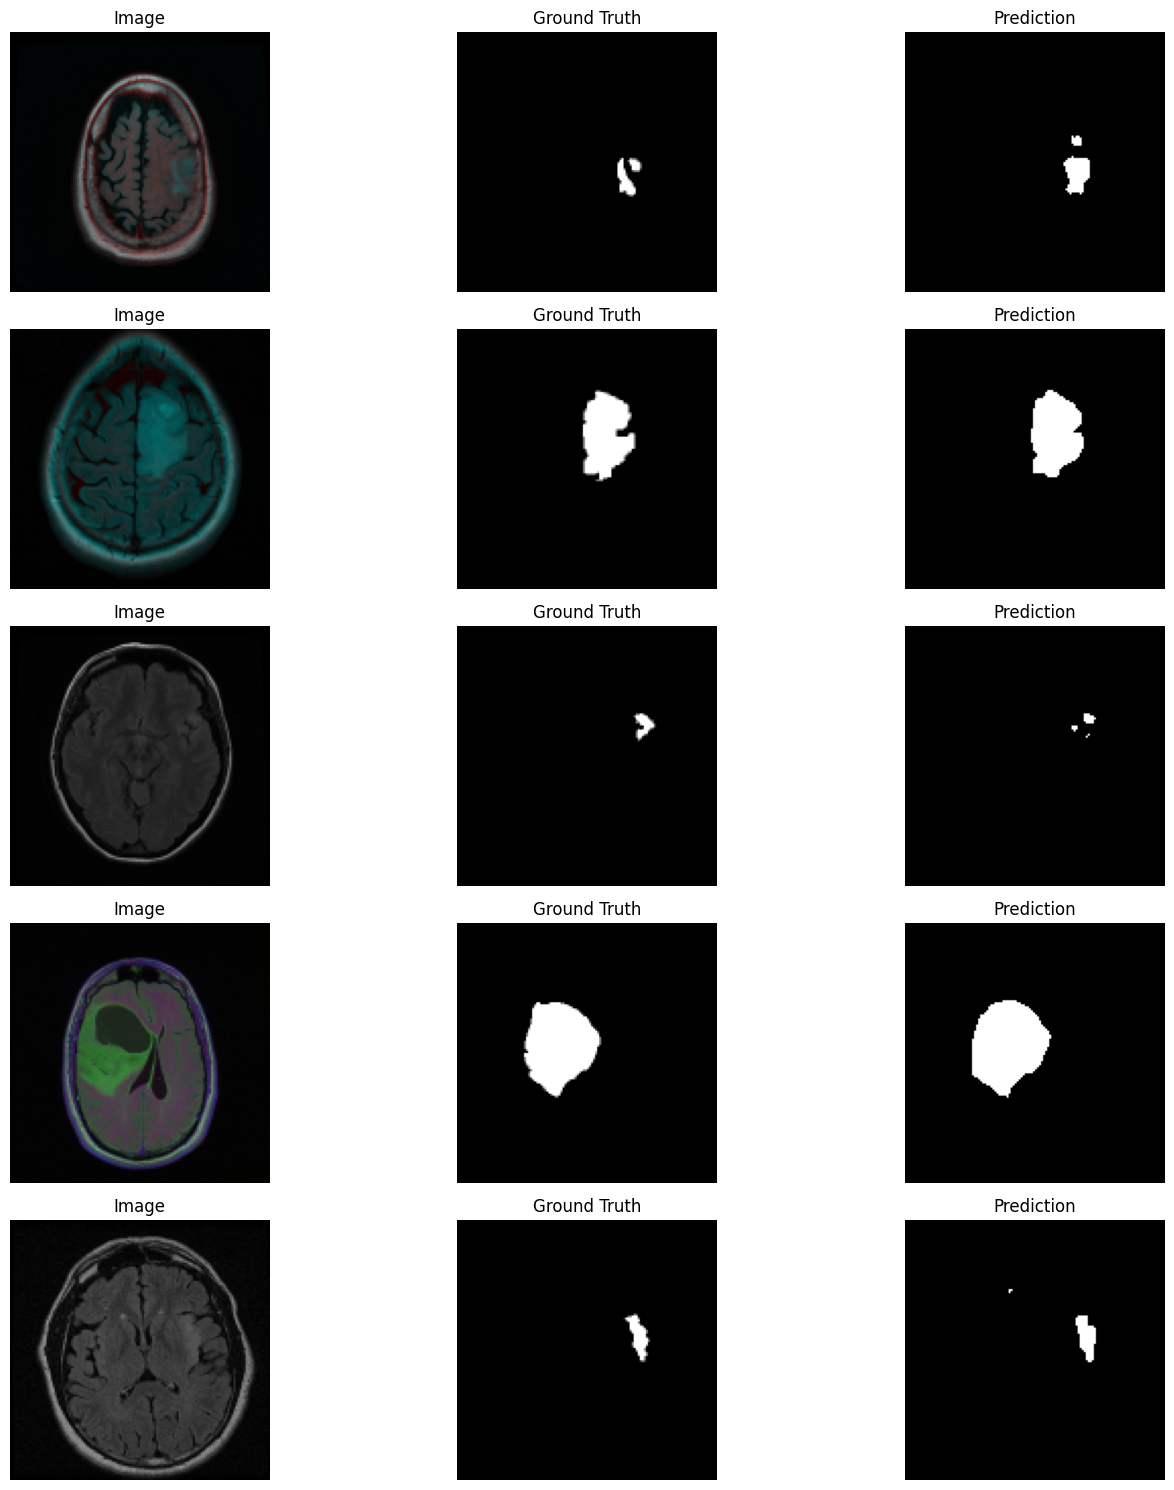

In [20]:
model = tf.keras.models.load_model('TumorSegNet_attbest.keras', compile=False)
visualize_predictions(model, vlds)